# IMPORT LIBRARY

In [82]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

Cell code di atas merupakan bagian dari proses awal dalam project pengolahan citra digital dan klasifikasi menggunakan Python. Baris-baris pertama mengimpor berbagai library penting yang digunakan dalam machine learning. 
- os digunakan untuk berinteraksi dengan sistem file
- cv2 (OpenCV) dimanfaatkan untuk membaca dan memproses citra
- matplotlib.pyplot dan seaborn digunakan untuk visualisasi data dan hasil klasifikasi
- numpy dan pandas berfungsi untuk manipulasi array dan data tabular
- scikit-learn digunakan secara ekstensif dalam proses pembelajaran mesin, termasuk pemisahan data (train_test_split), validasi silang (cross_val_predict), seleksi fitur (SelectKBest dan f_classif), normalisasi (MinMaxScaler), serta metrik evaluasi seperti akurasi, presisi, recall, F1-score, dan confusion matric
- classifier yang digunakan meliputi Random Forest, Support Vector Machine (SVM), dan K-Nearest Neighbors (KNN)
- skimage.feature digunakan untuk ekstraksi fitur tekstur dari citra menggunakan metode GLCM (Gray Level Co-occurrence Matrix)
- scipy.stats.entropy digunakan untuk menghitung nilai entropi dari distribusi data.

## Data Loading

Buat struktur folder dataset sebagai berikut:
```
.
└──dataset
    ├── label1
	├── image1.jpg
	├── image2.jpg
	└── image3.jpg
    ├── label2
    └── label3
    └── dst...
```

In [83]:
data = []
labels = []
file_name = []
for sub_folder in os.listdir("dataset\\"):
    sub_folder_files = os.listdir(os.path.join("dataset\\", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("dataset\\", sub_folder, filename)
        img = cv.imread(img_path)
        
        data.append(img)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)

Cell code di atas digunakan untuk membaca semua gambar yang ada di dalam folder bernama dataset. Di dalam folder tersebut, terdapat sub-folder yang masing-masing mewakili kelas atau kategori gambar. Cell code ini akan mengecek setiap sub-folder dan membaca semua file gambar di dalamnya satu per satu. Gambar-gambar yang dibaca akan disimpan ke dalam list data, sedangkan nama sub-folder tempat gambar ditemukan akan dianggap sebagai label atau kategori gambar tersebut, dan disimpan di list labels. Selain itu, nama file (tanpa ekstensi) dari setiap gambar juga disimpan di list file_name. Tujuan dari proses ini adalah mengumpulkan semua data gambar beserta label kategorinya agar bisa digunakan nanti dalam proses pelatihan model klasifikasi.

## Data Preparation

### Define Preprocessing Function


In [84]:
def resize(img, target_height, target_width):
    height, width = img.shape
    resized_img = np.zeros((target_height, target_width), dtype=np.uint8)
    
    scale_x = width / target_width
    scale_y = height / target_height

    for i in range(target_height):
        for j in range(target_width):
            orig_x = min(int(j * scale_x), width - 1)
            orig_y = min(int(i * scale_y), height - 1)
            resized_img[i, j] = img[orig_y, orig_x]

    return resized_img

def normalize(img):
    min_val = np.min(img)
    max_val = np.max(img)
    normalized_img = (img - min_val) / (max_val - min_val) * 255
    return normalized_img.astype(np.uint8)

def percobaan_1(img, target_height, target_width):
    gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    resized_img = resize(gray_img, target_height, target_width)
    normalize_img = normalize(resized_img)
    return normalize_img

### Preprocessing

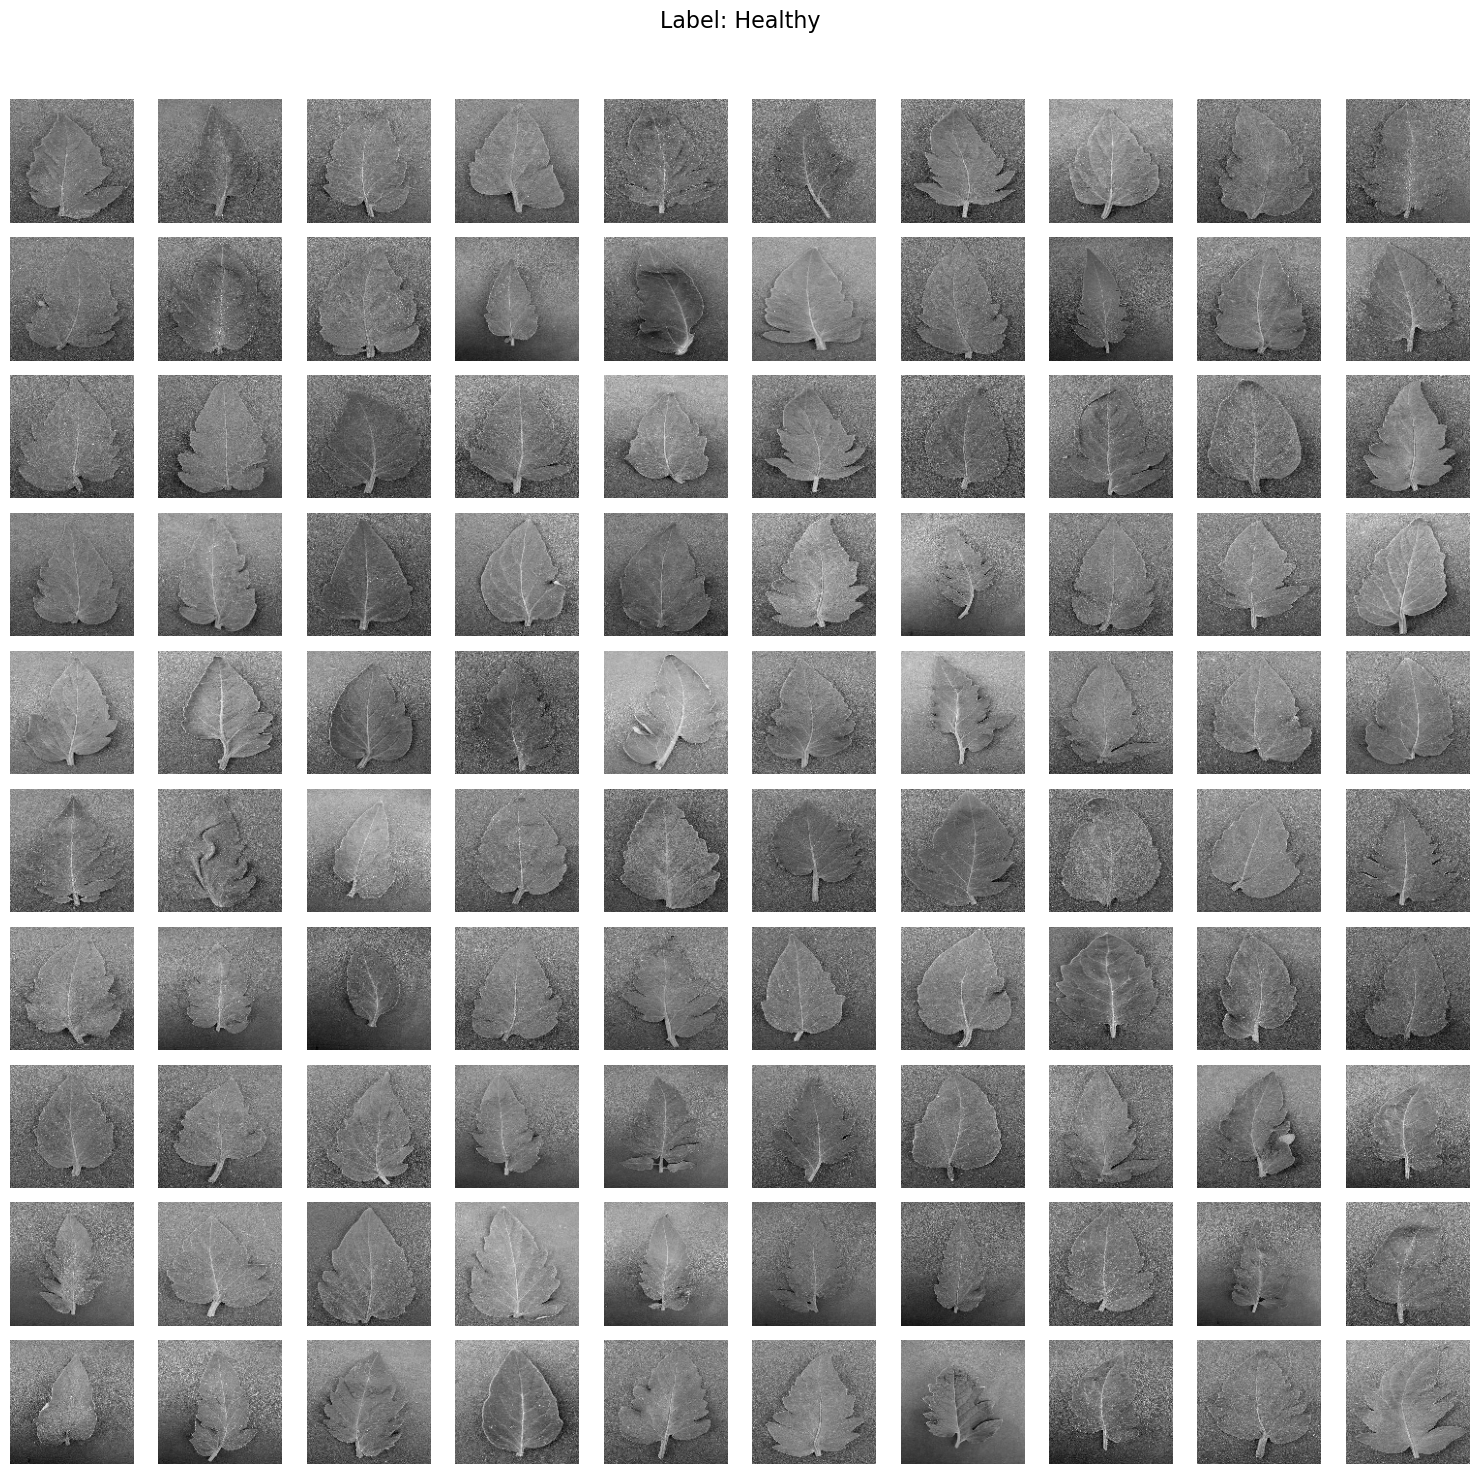

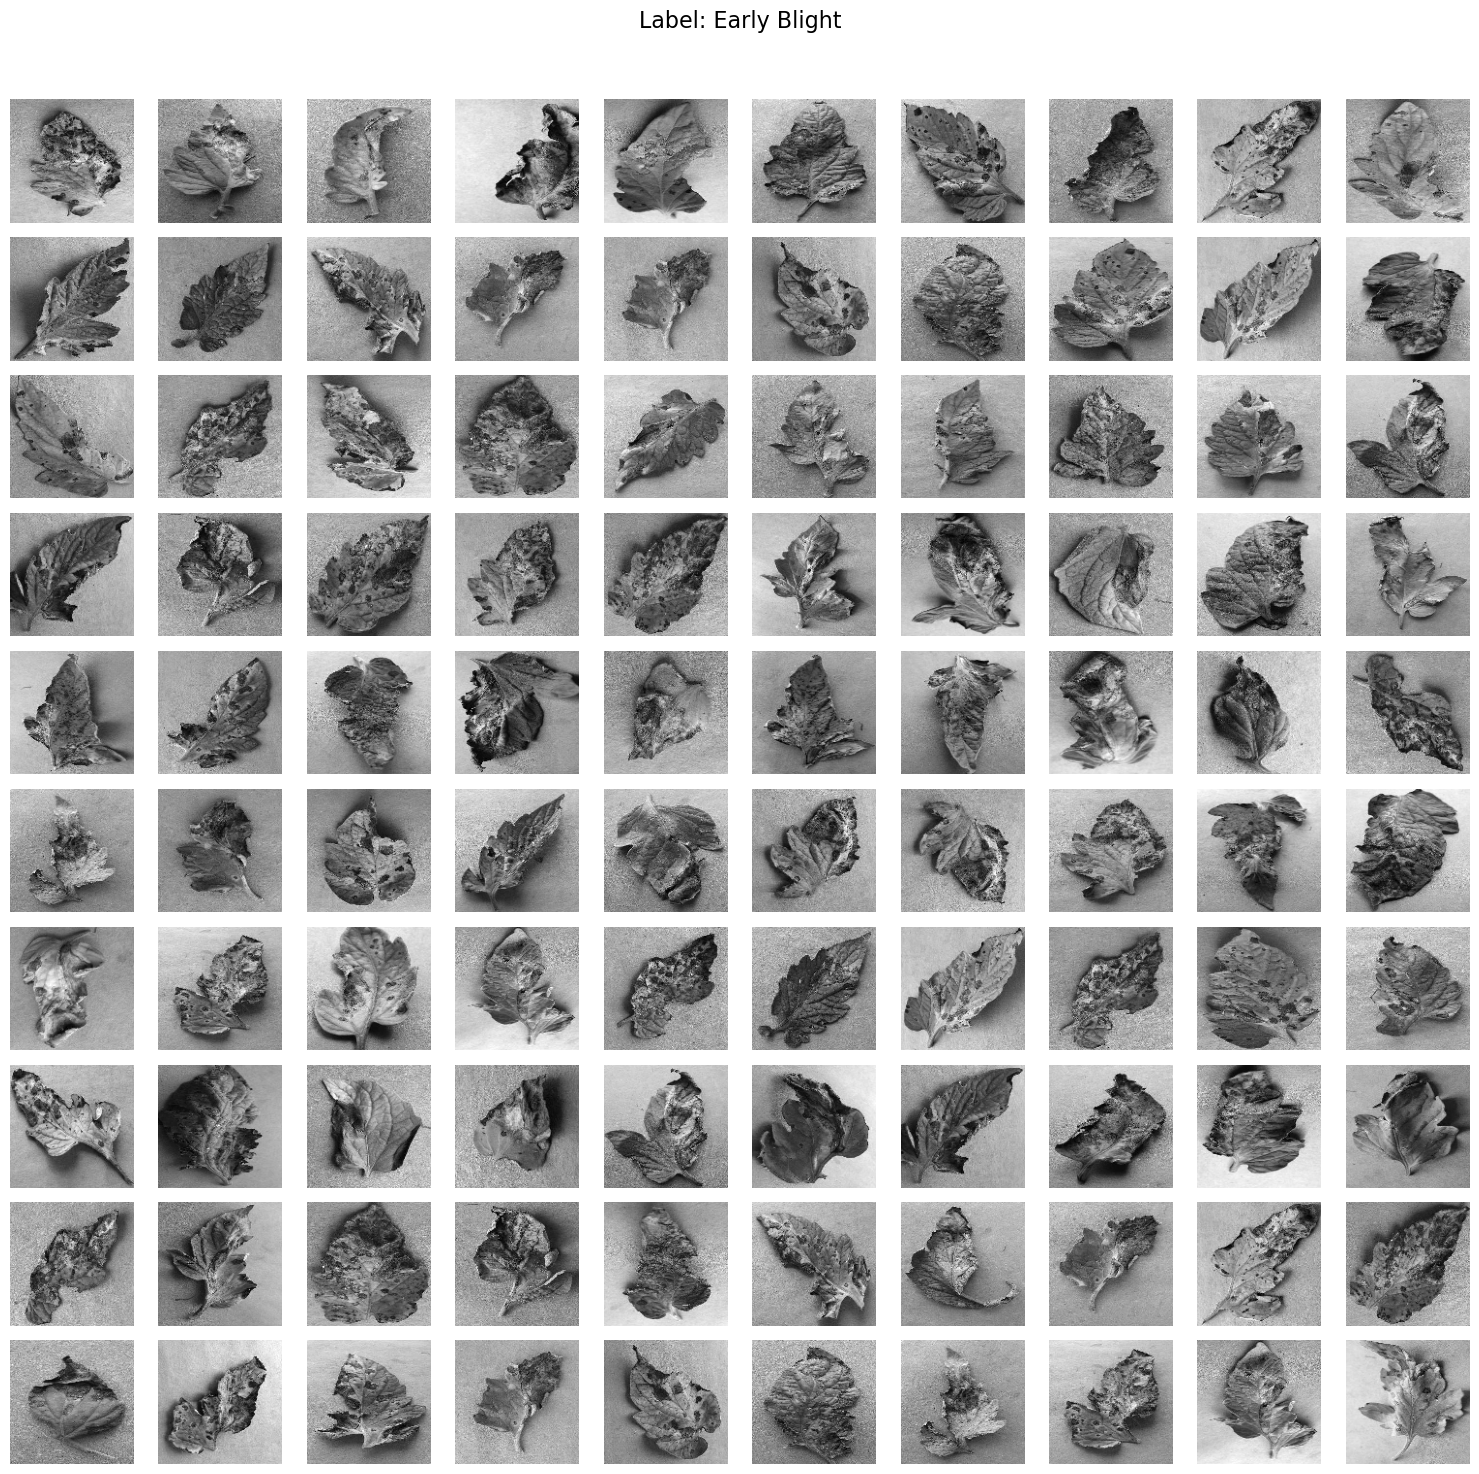

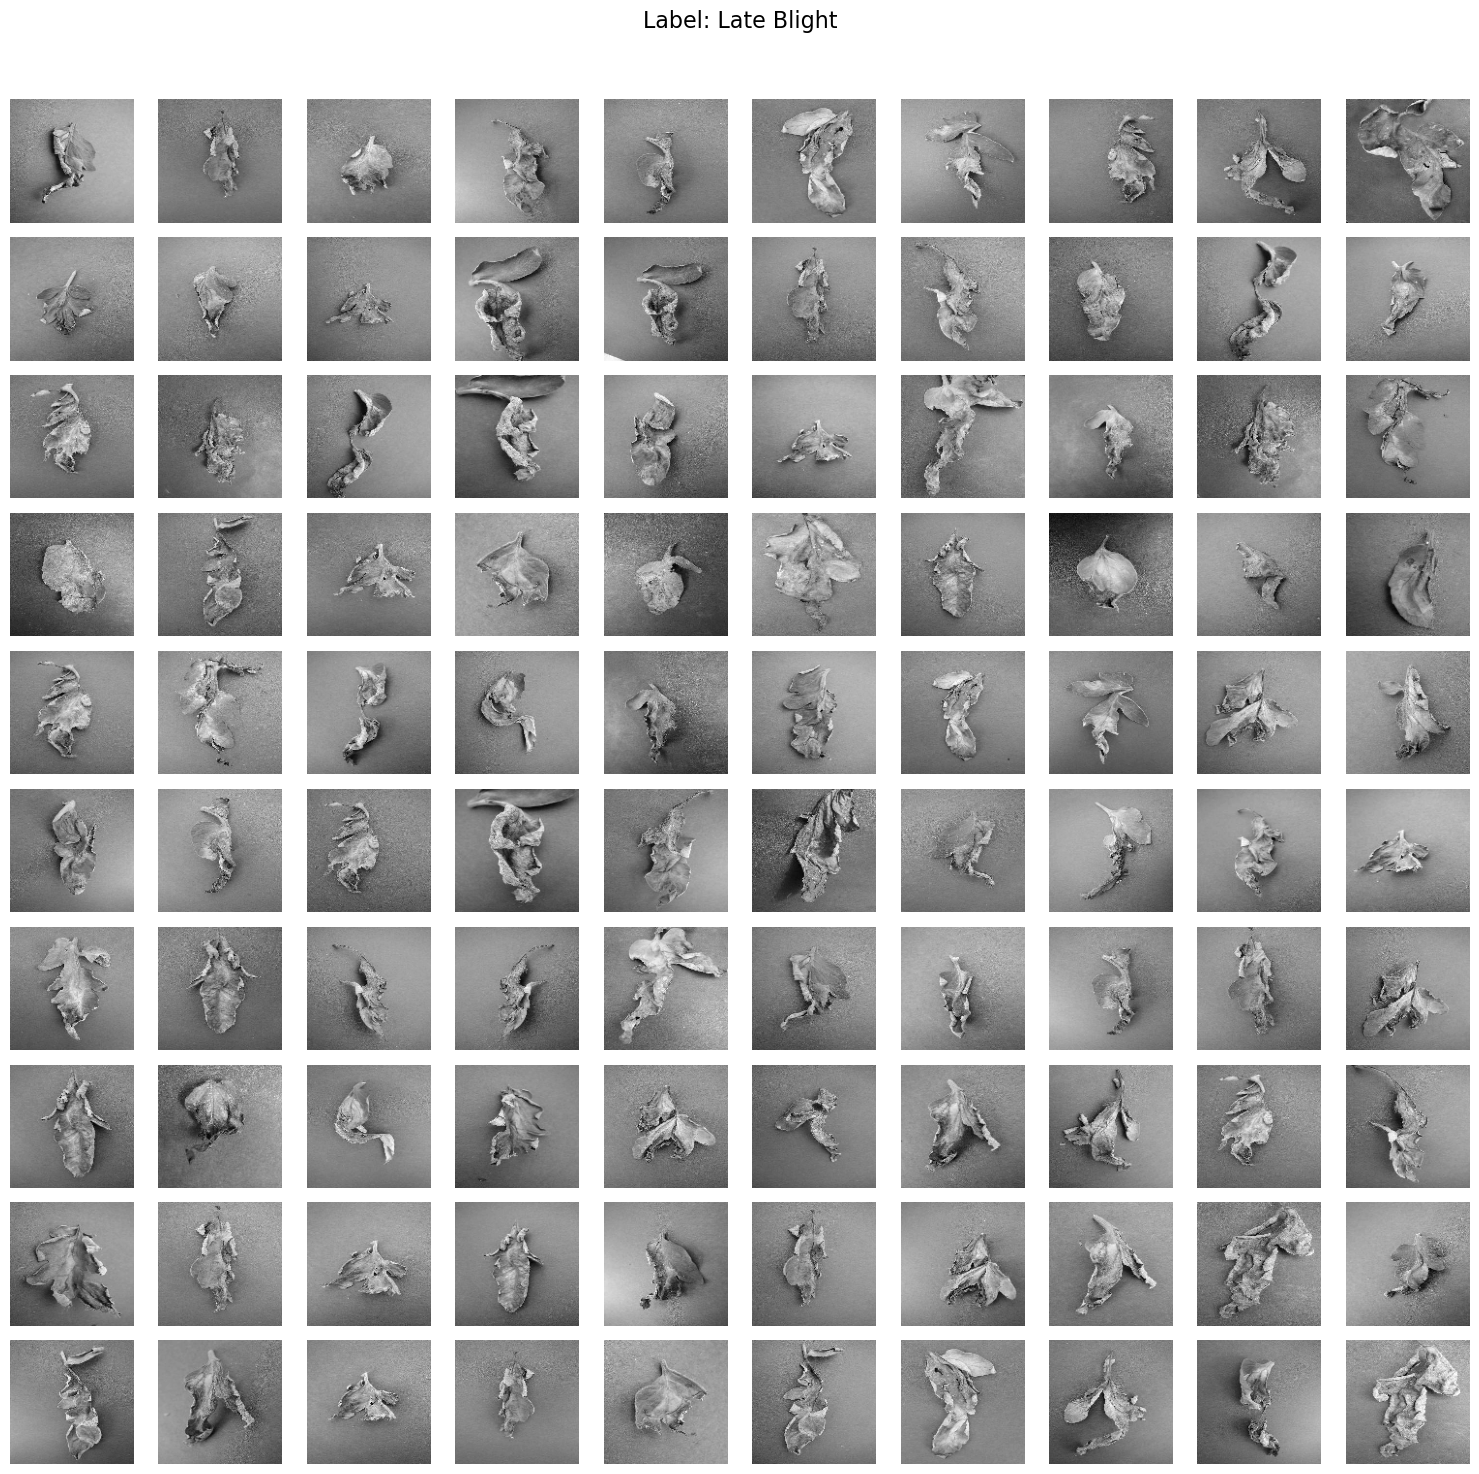

In [85]:
# pada bagian ini bisa gunakan data yang sebelum augmentasi atau setelah augmentasi
dataPreprocessed = [percobaan_1(img, 128, 128) for img in data]
dataPreprocessed = np.array(dataPreprocessed)
labels = np.array(labels)

label_names = {
    "Label 1": "Healthy",
    "Label 2": "Early Blight",
    "Label 3": "Late Blight"
}

# Loop untuk setiap label
for label_code in label_names:
    # Ambil 100 index pertama dengan label ini
    idxs = np.where(labels == label_code)[0][:100]

    # Buat figure
    plt.figure(figsize=(15, 15))
    plt.suptitle(f"Label: {label_names[label_code]}", fontsize=16)

    for i, idx in enumerate(idxs):
        plt.subplot(10, 10, i + 1)
        plt.imshow(dataPreprocessed[idx], cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()


### Feature Extraction

In [86]:
def glcm(image, derajat):
    image = (image * 255).astype(np.uint8)  
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

Cell code di atas merupakan fungsi glcm yang digunakan untuk menghitung matriks ko-ocurrence tingkat abu-abu (GLCM) dari sebuah gambar, yang merupakan salah satu metode untuk mengekstrak fitur tekstur dari citra. Fungsi ini menerima dua parameter yaitu image (gambar dalam format array) dan derajat (sudut arah pergeseran piksel yang ingin dihitung, seperti 0, 45, 90, atau 135 derajat). 

Pertama, gambar dikonversi ke format 8-bit (rentang 0–255) agar sesuai dengan kebutuhan fungsi GLCM. Lalu, berdasarkan nilai derajat yang diberikan, fungsi mengatur arah sudut pergeseran dalam satuan radian. Jika nilai derajat tidak termasuk salah satu dari 0, 45, 90, atau 135, maka akan muncul pesan kesalahan. Setelah itu, fungsi graycomatrix dari pustaka skimage digunakan untuk menghitung matriks GLCM dengan jarak antar piksel sebesar 1, hasilnya simetris dan ternormalisasi. Matriks GLCM yang dihasilkan kemudian dikembalikan oleh fungsi ini dan dapat digunakan untuk menghitung ciri-ciri tekstur seperti kontras, homogenitas, dan energi.

In [87]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

Cell code di atas merupakan fungsi correlation yang digunakan untuk menghitung nilai korelasi dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix), yaitu matriks yang merepresentasikan hubungan tekstur antar piksel dalam gambar. Fungsi ini menerima satu parameter, yaitu matriks, yang merupakan hasil dari fungsi graycomatrix. Di dalam fungsi, digunakan graycoprops dari pustaka skimage.feature untuk menghitung properti statistik GLCM dengan jenis 'correlation'. Nilai korelasi ini mengukur seberapa besar hubungan linier antara piksel-piksel berpasangan dalam gambar—semakin tinggi nilainya, semakin kuat keterkaitan antar piksel. Hasil dari graycoprops berbentuk array 2 dimensi, dan fungsi ini hanya mengambil nilai pertama (baris ke-0, kolom ke-0), lalu mengembalikannya sebagai output.

In [88]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

Cell code di atas merupakan fungsi dissimilarity yang digunakan untuk menghitung nilai ketidaksamaan (dissimilarity) dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix), yang merupakan salah satu ukuran tekstur dalam gambar. Fungsi ini menerima input berupa matriks, yaitu hasil dari perhitungan GLCM sebelumnya. Di dalamnya, digunakan fungsi graycoprops dari pustaka skimage.feature dengan parameter 'dissimilarity' untuk mendapatkan nilai ketidaksamaan antar piksel. Nilai dissimilarity menggambarkan seberapa besar perbedaan tingkat keabuan antar pasangan piksel dalam gambar—semakin besar nilainya, semakin tidak mirip piksel-piksel yang bersebelahan. Seperti sebelumnya, hasil yang didapat berupa array 2 dimensi, dan fungsi ini mengambil nilai di posisi [0, 0] sebagai hasil akhirnya.

In [89]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

Cell code di atas merupakan fungsi homogenity yang digunakan untuk menghitung nilai homogenitas dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix), yang merupakan salah satu fitur tekstur pada gambar. Fungsi ini menerima satu parameter, yaitu matriks, yang merupakan hasil dari perhitungan GLCM. Di dalamnya, digunakan fungsi graycoprops dari pustaka skimage.feature dengan parameter 'homogeneity' untuk menghitung sejauh mana piksel-piksel yang berdekatan memiliki nilai keabuan yang serupa. Semakin tinggi nilai homogenitas, berarti piksel-piksel dalam gambar cenderung memiliki tingkat keabuan yang mirip atau tidak banyak perbedaan. Hasilnya berbentuk array dua dimensi, dan fungsi ini hanya mengambil nilai pada indeks [0, 0] sebagai output.

In [90]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

Cell code di atas merupakan fungsi contrast yang digunakan untuk menghitung nilai kontras dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix), yang merupakan salah satu ciri tekstur penting dalam analisis citra. Fungsi ini menerima satu parameter, yaitu matriks, yaitu hasil dari perhitungan GLCM. Di dalam fungsi, digunakan graycoprops dari pustaka skimage.feature dengan parameter 'contrast' untuk menghitung perbedaan intensitas antara piksel-piksel yang berdekatan dalam gambar. Nilai kontras menunjukkan seberapa besar perbedaan antara piksel terang dan gelap—semakin tinggi nilai kontras, semakin tajam perbedaan antara piksel tersebut. Hasil perhitungan berupa array dua dimensi, dan fungsi ini hanya mengambil nilai pada indeks [0, 0] sebagai hasil akhirnya.

In [91]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

Cell code di atas merupakan fungsi ASM yang digunakan untuk menghitung nilai ASM (Angular Second Moment) dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix), yang merupakan salah satu fitur tekstur dalam analisis citra. ASM juga sering disebut sebagai energy, dan mengukur keseragaman (uniformity) atau keteraturan pola pada gambar. Fungsi ini menerima parameter matriks, yaitu hasil dari perhitungan GLCM, kemudian menggunakan fungsi graycoprops dari pustaka skimage.feature dengan parameter 'ASM' untuk menghitung nilainya. Hasil dari fungsi ini berbentuk array dua dimensi, dan nilai pada posisi [0, 0] diambil sebagai output. Nilai ASM yang tinggi menunjukkan bahwa gambar memiliki pola atau tekstur yang seragam dan berulang secara konsisten. 

In [92]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

Cell code di atas merupakan fungsi energy yang digunakan untuk menghitung nilai energi dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix), yang merupakan salah satu fitur tekstur dalam pengolahan citra. Nilai energi ini sebenarnya adalah akar kuadrat dari nilai ASM (Angular Second Moment), dan digunakan untuk mengukur tingkat keseragaman pada pola tekstur suatu gambar. Fungsi ini menerima parameter matriks, yaitu hasil dari perhitungan GLCM, lalu menggunakan fungsi graycoprops dari pustaka skimage.feature dengan parameter 'energy' untuk menghitung nilai energinya. Hasilnya berupa array dua dimensi, dan hanya nilai pada indeks [0, 0] yang dikembalikan sebagai output. Semakin tinggi nilai energi, semakin seragam atau teratur tekstur gambar tersebut.

In [93]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

Cell code di atas merupakan fungsi entropyGlcm digunakan untuk menghitung nilai entropi dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix), yang merupakan ukuran ketidakpastian atau keragaman dalam tekstur gambar. Fungsi ini menerima input matriks, yaitu hasil dari perhitungan GLCM, kemudian mengubah matriks tersebut menjadi sebuah vektor satu dimensi menggunakan metode .ravel() agar bisa diproses lebih mudah. Selanjutnya, fungsi entropy dari pustaka scipy.stats digunakan untuk menghitung entropi, yaitu seberapa acak atau tidak teraturnya distribusi nilai dalam matriks tersebut. Nilai entropi yang tinggi menandakan tekstur gambar lebih kompleks dan kurang teratur, sementara nilai yang rendah menunjukkan tekstur yang lebih sederhana dan teratur. 

In [94]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

Cell code di atas  digunakan untuk menghitung matriks GLCM (Gray Level Co-occurrence Matrix) pada setiap gambar yang sudah diproses dan disimpan dalam list dataPreprocessed. Untuk setiap gambar, kode ini menghitung matriks GLCM pada empat arah sudut yang berbeda, yaitu 0 derajat, 45 derajat, 90 derajat, dan 135 derajat, dengan menggunakan fungsi glcm yang sudah didefinisikan sebelumnya. Setelah matriks GLCM untuk setiap sudut berhasil dihitung, hasilnya disimpan secara terpisah dalam empat list berbeda: Derajat0, Derajat45, Derajat90, dan Derajat135. Dengan cara ini, setiap gambar memiliki empat representasi tekstur berdasarkan sudut arah piksel yang berbeda, yang nantinya bisa digunakan untuk mengekstrak fitur tekstur lebih lengkap guna analisis atau klasifikasi.

In [95]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []


Cell code di atas mendefinisikan beberapa list kosong yang nantinya akan digunakan untuk menyimpan nilai fitur tekstur yang dihitung dari matriks GLCM pada berbagai sudut arah. Ada delapan jenis fitur tekstur yang disiapkan yaitu kontras, dissimilarity (ketidaksamaan), homogenitas, entropi, ASM (Angular Second Moment), energi, dan korelasi. Setiap fitur tersebut disiapkan dalam empat list terpisah yang merepresentasikan nilai pada sudut 0°, 45°, 90°, dan 135°. Dengan membuat list-list ini, program siap untuk menyimpan hasil perhitungan fitur tekstur dari setiap gambar dan sudut arah yang berbeda, sehingga analisis tekstur bisa dilakukan secara detail dan menyeluruh berdasarkan berbagai arah matriks GLCM.

In [96]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

Cell code di atas digunakan untuk menghitung nilai korelasi dari matriks GLCM (Gray Level Co-occurrence Matrix) pada setiap gambar yang sudah diproses. Untuk setiap gambar dalam dataPreprocessed, kode ini mengambil masing-masing matriks GLCM pada sudut 0°, 45°, 90°, dan 135° yang sebelumnya telah disimpan dalam list Derajat0, Derajat45, Derajat90, dan Derajat135. Kemudian, fungsi correlation digunakan untuk menghitung nilai korelasi dari masing-masing matriks tersebut. Nilai korelasi ini menggambarkan hubungan atau keterkaitan antar piksel dalam gambar. Setelah dihitung, setiap nilai korelasi disimpan ke dalam list yang sesuai berdasarkan sudutnya, yaitu correlation0, correlation45, correlation90, dan correlation135. Maka setiap gambar akan memiliki empat nilai korelasi yang mencerminkan arah hubungan teksturnya dari berbagai sudut pandang.

In [97]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [98]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [99]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [100]:
for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [101]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [102]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

In [ ]:
features = []

for i in range(len(dataPreprocessed)):
    fitur = [
        correlation0[i], correlation45[i], correlation90[i], correlation135[i],
        dissimilarity0[i], dissimilarity45[i], dissimilarity90[i], dissimilarity135[i],
        Kontras0[i], Kontras45[i], Kontras90[i], Kontras135[i],
        homogenity0[i], homogenity45[i], homogenity90[i], homogenity135[i],
        entropy0[i], entropy45[i], entropy90[i], entropy135[i],
        ASM0[i], ASM45[i], ASM90[i], ASM135[i],
        energy0[i], energy45[i], energy90[i], energy135[i],
    ]
    features.append(fitur)

features = np.array(features)
labels = np.array(labels)


### Write the extraction's results to CSV 

In [104]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak


Filename    Label   Contrast0  \
0    c1c04a55-0dd5-48e2-9cc6-76bbcc1899fd___GH_HL L...  Label 1  646.129245   
1    c1dfd66e-7c0c-40a7-8280-0aa1aaf5436b___GH_HL L...  Label 1  738.006582   
2    c2c1758f-3576-4e8a-9853-5f11ac4d20d6___GH_HL L...  Label 1  736.876722   
3    c6acee22-6c56-41a8-ae90-26c6064e0261___GH_HL L...  Label 1  393.775344   
4    c7cedd2f-dfae-4232-9cab-d75197d48948___GH_HL L...  Label 1  974.835076   
..                                                 ...      ...         ...   
295                                           img3.JPG  Label 3  391.062315   
296                                           img4.JPG  Label 3  346.762549   
297                                           img5.JPG  Label 3  366.194636   
298                                           img6.JPG  Label 3  267.152190   
299                                           img7.JPG  Label 3  481.273314   

      Contrast45  Contrast90  Contrast135  Homogeneity0  Homogeneity45  \
0     672.982082  647.465244   653.440325      0.065801       0.061459   
1     757.266973  722.803396   747.224688      0.056035       0.055790   
2     763.212226  722.406004   770.582615      0.059695       0.053884   
3     421.470457  390.734560   430.723355      0.076384       0.072036   
4    1005.679893  974.205709   996.832228      0.049492       0.047511   
..           ...         ...          ...           ...            ...   
295   511.492653  419.740465   485.760866      0.148687       0.131391   
296   394.360531  334.994771   482.482671      0.191324       0.150972   
297   469.410007  350.221641   400.847046      0.181659       0.146405   
298   307.388555  229.917200   308.701965      0.186242       0.161278   
299   651.966706  508.421813   602.789448      0.108937       0.097374   

     Homogeneity90  Homogeneity135  ...     ASM90    ASM135   Energy0  \
0         0.061611        0.063010  ...  0.000326  0.000325  0.018172   
1         0.057675        0.058330  ...  0.000302  0.000296  0.017374   
2         0.053230        0.055819  ...  0.000240  0.000240  0.015528   
3         0.072621        0.074600  ...  0.000367  0.000368  0.019399   
4         0.050516        0.050975  ...  0.000251  0.000249  0.015808   
..             ...             ...  ...       ...       ...       ...   
295       0.130138        0.126407  ...  0.000571  0.000552  0.024794   
296       0.158689        0.156634  ...  0.001865  0.001795  0.046102   
297       0.159299        0.147703  ...  0.000634  0.000612  0.026521   
298       0.165124        0.155872  ...  0.000543  0.000528  0.024502   
299       0.101262        0.095157  ...  0.000277  0.000271  0.017255   

     Energy45  Energy90  Energy135  Correlation0  Correlation45  \
0    0.018007  0.018051   0.018021      0.489339       0.464350   
1    0.017301  0.017372   0.017209      0.404128       0.388289   
2    0.015381  0.015477   0.015503      0.527179       0.507325   
3    0.019140  0.019169   0.019181      0.709938       0.687424   
4    0.015676  0.015851   0.015780      0.297642       0.272298   
..        ...       ...        ...           ...            ...   
295  0.023656  0.023898   0.023491      0.756939       0.682116   
296  0.042322  0.043190   0.042372      0.747500       0.714764   
297  0.024564  0.025179   0.024741      0.808001       0.754469   
298  0.022964  0.023300   0.022973      0.871289       0.852628   
299  0.016372  0.016646   0.016451      0.791927       0.718598   

     Correlation90  Correlation135  
0         0.485378        0.479814  
1         0.415877        0.396416  
2         0.533345        0.502601  
3         0.709947        0.680585  
4         0.295898        0.278789  
..             ...             ...  
295       0.738960        0.698153  
296       0.756020        0.651032  
297       0.816442        0.790354  
298       0.889939        0.852005  
299       0.779642        0.739833  

[300 rows x 30 columns]

### Features Selection

pada bagian seleksi fitur ini bisa menggunakan metode seperti
- PCA
- LDA
- t-SNE
- Chi-square
- ANOVA
- Autoencoder
- correlation
- dll

berikut contoh menggunakan correlation:

<Axes: >

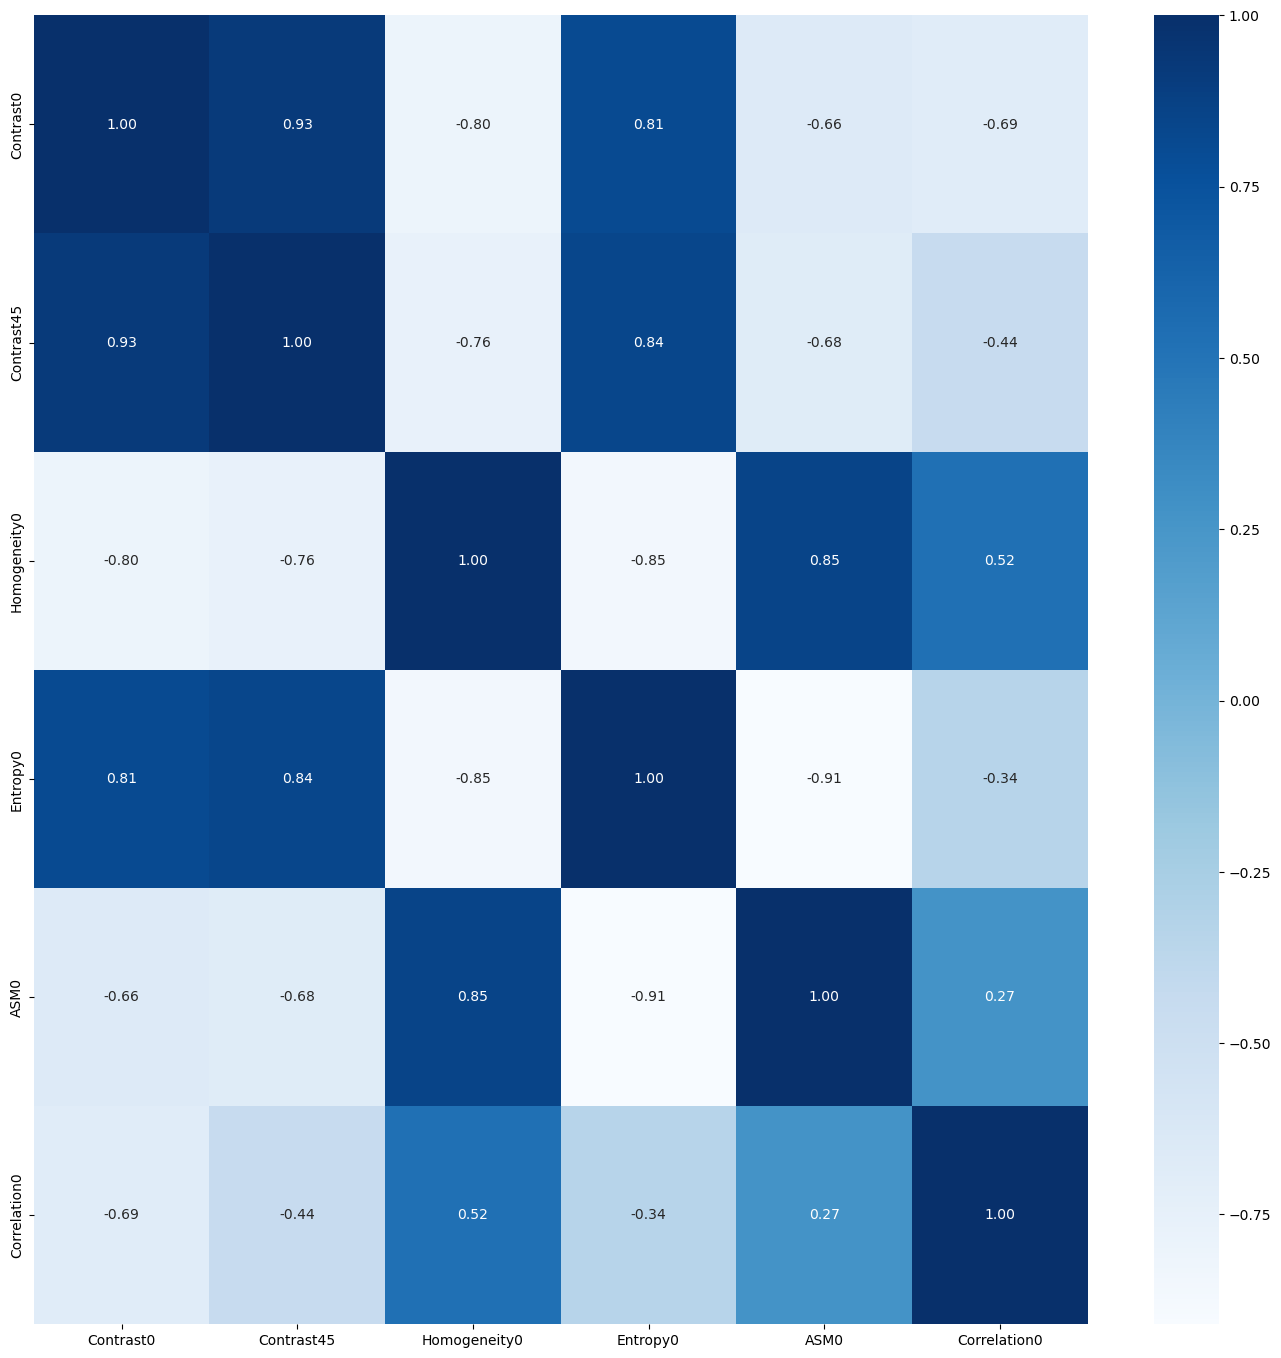

In [ ]:
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

threshold = 0.95 
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

#### Method ANOVA

<Axes: >

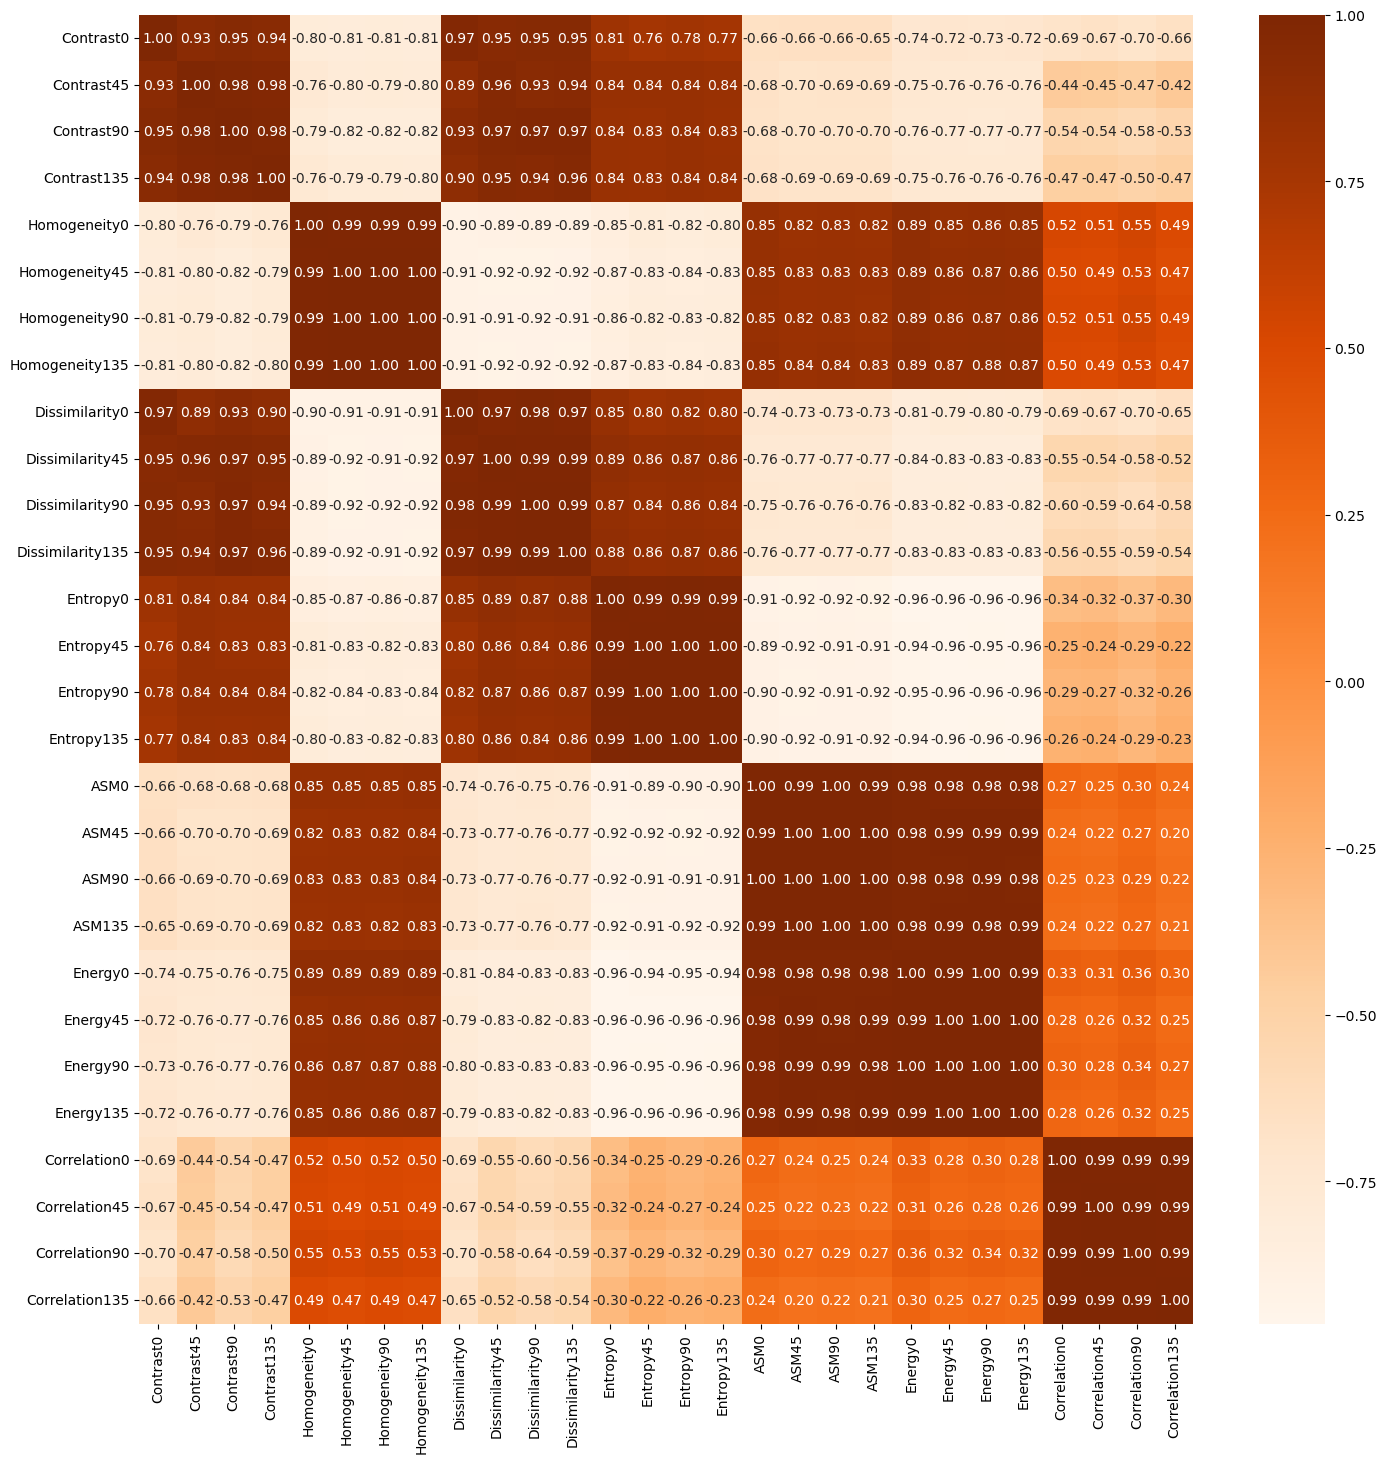

In [ ]:
X = hasilEkstrak.drop(columns=['Label', 'Filename'])
y = hasilEkstrak['Label']

anova_selector = SelectKBest(score_func=f_classif, k='all') 
anova_selector.fit(X, y)

anova_scores = anova_selector.scores_
feature_names = X.columns

threshold = 5
selected_features = feature_names[anova_scores > threshold]

x_new = X[selected_features]
x_new

plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Oranges', fmt=".2f")


## Splitting Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    x_new, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)


print("Data Latih:", X_train.shape)
print("Data Uji:", X_test.shape)


Data Latih: (240, 28)
Data Uji: (60, 28)


## Feature Normalization

berikut metode normalisasi yang bisa digunakan:
- Min-Max Scaling
- Standardization (Z-score)
- Robust Scaling
- MaxAbsScaler
- dll

berikut contoh menggunakan Standardization (Z-score):

In [ ]:
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

### Min-Max Scaling

In [109]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Modeling

### Define Model

In [ ]:
def generateClassificationReport(y_true, y_pred):
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    
    print("Accuracy:", accuracy_score(y_true, y_pred))

rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

### Train Random Forest Classifier

In [ ]:
rf.fit(X_train, y_train)

print("------Training Set------")
y_pred_train = rf.predict(X_train)
generateClassificationReport( y_train, y_pred_train)

print("\n------Testing Set------")
y_pred_test = rf.predict(X_test)
generateClassificationReport( y_test, y_pred_test)

------Training Set------
Classification Report:
              precision    recall  f1-score   support

     Label 1       1.00      1.00      1.00        80
     Label 2       0.99      0.99      0.99        80
     Label 3       0.99      0.99      0.99        80

    accuracy                           0.99       240
   macro avg       0.99      0.99      0.99       240
weighted avg       0.99      0.99      0.99       240

Confusion Matrix:
[[80  0  0]
 [ 0 79  1]
 [ 0  1 79]]
Accuracy: 0.9916666666666667

------Testing Set------
Classification Report:
              precision    recall  f1-score   support

     Label 1       0.87      1.00      0.93        20
     Label 2       0.95      0.95      0.95        20
     Label 3       1.00      0.85      0.92        20

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60

Confusion Matrix:
[[20  0  0]
 [ 1 19  0]
 [ 2  1 17]]
Acc

### Train SVM Classifier

In [ ]:
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred_train = svm.predict(X_train)
generateClassificationReport( y_train, y_pred_train)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred_test = svm.predict(X_test)
generateClassificationReport( y_test, y_pred_test)


------Training Set------
Classification Report:
              precision    recall  f1-score   support

     Label 1       0.97      0.95      0.96        80
     Label 2       0.93      0.99      0.96        80
     Label 3       0.97      0.94      0.96        80

    accuracy                           0.96       240
   macro avg       0.96      0.96      0.96       240
weighted avg       0.96      0.96      0.96       240

Confusion Matrix:
[[76  2  2]
 [ 1 79  0]
 [ 1  4 75]]
Accuracy: 0.9583333333333334

------Testing Set------
Classification Report:
              precision    recall  f1-score   support

     Label 1       0.90      0.90      0.90        20
     Label 2       0.83      1.00      0.91        20
     Label 3       1.00      0.80      0.89        20

    accuracy                           0.90        60
   macro avg       0.91      0.90      0.90        60
weighted avg       0.91      0.90      0.90        60

Confusion Matrix:
[[18  2  0]
 [ 0 20  0]
 [ 2  2 16]]
Ac

### Train KNN Classifier

In [113]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred_train = knn.predict(X_train)
generateClassificationReport( y_train, y_pred_train)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred_test = knn.predict(X_test)
generateClassificationReport( y_test, y_pred_test)



------Training Set------
Classification Report:
              precision    recall  f1-score   support

     Label 1       0.96      0.95      0.96        80
     Label 2       0.99      0.96      0.97        80
     Label 3       0.94      0.97      0.96        80

    accuracy                           0.96       240
   macro avg       0.96      0.96      0.96       240
weighted avg       0.96      0.96      0.96       240

Confusion Matrix:
[[76  1  3]
 [ 1 77  2]
 [ 2  0 78]]
Accuracy: 0.9625

------Testing Set------
Classification Report:
              precision    recall  f1-score   support

     Label 1       0.83      0.95      0.88        20
     Label 2       0.95      1.00      0.98        20
     Label 3       0.94      0.75      0.83        20

    accuracy                           0.90        60
   macro avg       0.91      0.90      0.90        60
weighted avg       0.91      0.90      0.90        60

Confusion Matrix:
[[19  0  1]
 [ 0 20  0]
 [ 4  1 15]]
Accuracy: 0.9


## Evaluation With Confusion Matrix

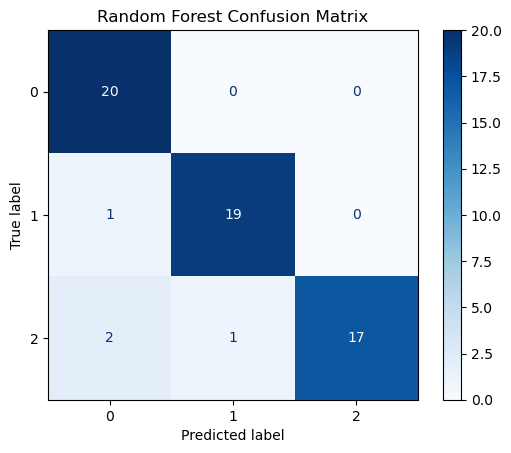

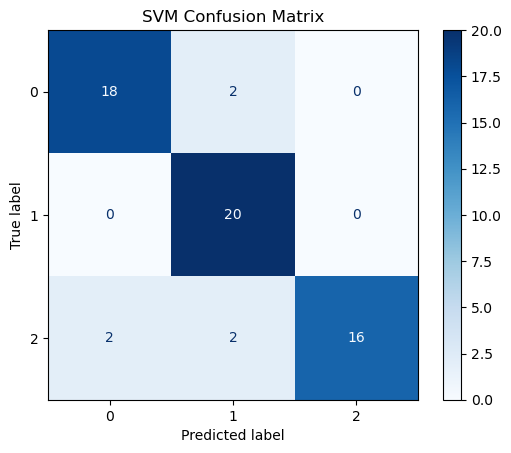

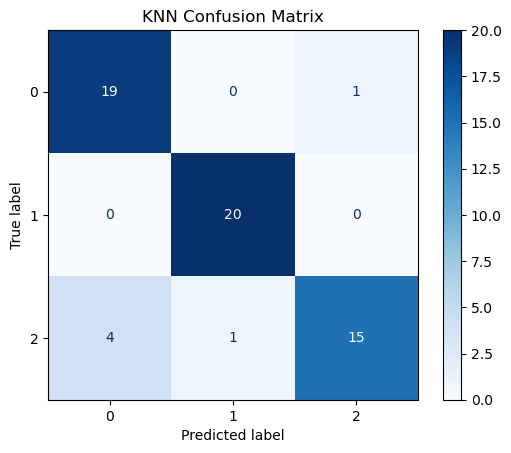

In [114]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")